In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

import mplhep
import zfit

mplhep.set_style('CMS')
zfit.__version__

'0.5.6'

In [36]:
image_name = '-0.5065000057220459__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev269'

In [42]:
from glob import glob

In [50]:
ima.shape

(576, 576)

In [41]:
image_name.split('.png')[0]

'-0.5065000057220459__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev269'

### load image

In [2]:
im = Image.open('images/-0.5065000057220459__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev269.png')
# im = Image.open('images/0.7410642504692078__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run4_ev447.png')
# im = Image.open('images/0.7402061223983765__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev937.png')
# im = Image.open('images/-0.3499999940395355__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run2_ev87.png')
# im = Image.open('images/0.48575398325920105__CYGNO_60_40_ER_1_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev0.png')
# im = Image.open('images/3.1136999130249023__CYGNO_60_40_He_NR_6_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run1_ev809.png')

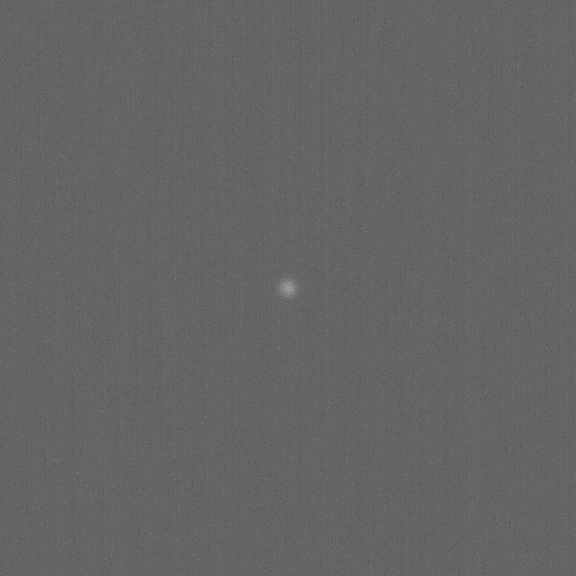

In [3]:
im

In [4]:
ima = np.array(im)

In [5]:
step_left, step_right = 60, 60
# step_left, step_right = 60, 90
left, right = round(ima.shape[0]/2 - step_left), round(ima.shape[0]/2 + step_right)
ima_x = np.sum(ima[left:right, left:right], axis=0)
ima_y = np.sum(ima[left:right, left:right], axis=1)

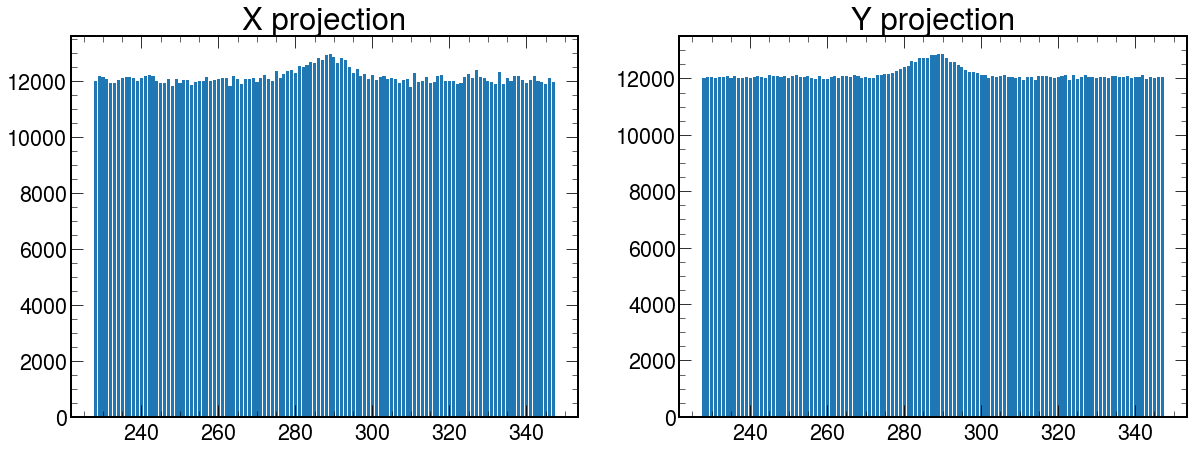

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].bar(range(left, right), ima_x)
axs[0].set_title('X projection')
axs[1].bar(range(left, right), ima_y)
axs[1].set_title('Y projection')
plt.show()

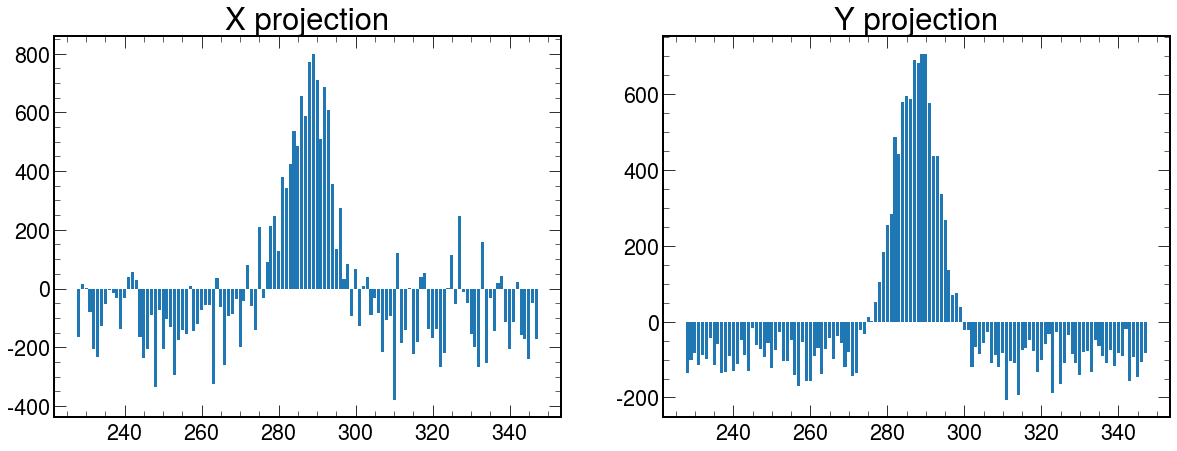

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].bar(range(left, right), ima_x - np.mean(ima_x)) # note that mean is biased by the signal
axs[0].set_title('X projection')
axs[1].bar(range(left, right), ima_y - np.mean(ima_y)) # note that mean is biased by the signal
axs[1].set_title('Y projection')
plt.show()

### model

In [8]:
# create space
obs = zfit.Space("obs", limits=(left, right))

# parameters
mu = zfit.Parameter("mu", left + (right-left)/2, left, right)
sigma = zfit.Parameter("sigma", 10., 0.01, right - left)
# lambd = zfit.Parameter("lambda", -0.01, -1, -0.000001)

# model building, pdf creation
signal = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
# background = zfit.pdf.Exponential(lambd, obs=obs)
background = zfit.pdf.Uniform(left, right, obs=obs) 

# n_bkg = zfit.Parameter('n_bkg', sum(ima_x))
# n_sig = zfit.Parameter('n_sig', 1000)
# gauss_extended = gauss.create_extended(n_sig)
# exp_extended = exponential.create_extended(n_bkg)
# uni_extended = uniform.create_extended(n_bkg)
# model = zfit.pdf.SumPDF([gauss_extended, uni_extended])

frac = zfit.Parameter("fraction", 0.1, 0, 1)
model = zfit.pdf.SumPDF([signal, background], fracs=frac)

### data

In [9]:
obs_edges = np.array(range(left, right + 1))
obs_bin_centers = (obs_edges[:-1] + obs_edges[1:])/2

In [10]:
# this is exact data
x_samples = np.repeat(obs_bin_centers, ima_x.astype(int))
y_samples = np.repeat(obs_bin_centers, ima_y.astype(int))

In [11]:
# # beware, this is sampling from a hist distribution (aka multinomial)
# take_fraction = .2
# x_samples = np.random.choice(obs_bin_centers, size=int(take_fraction*ima_x.sum()), p=ima_x/ima_x.sum())
# y_samples = np.random.choice(obs_bin_centers, size=int(take_fraction*ima_y.sum()), p=ima_y/ima_y.sum())

In [12]:
data_projx = zfit.data.Data.from_numpy(obs=obs, array=x_samples)
data_projy = zfit.data.Data.from_numpy(obs=obs, array=y_samples)
data_projx_np = data_projx[:, 0].numpy()
data_projy_np = data_projy[:, 0].numpy()

In [13]:
# for further plotting
obs_grid = np.linspace(left, right, 1000)
n_bins = 40
n_sample_x = len(x_samples)
n_sample_y = len(y_samples)
plot_scaling_x = n_sample_x / n_bins * obs.area()
plot_scaling_y = n_sample_y / n_bins * obs.area()

<ipython-input-13-680f3204f67a>:6: UserWarning: The function <function Space.area at 0x2b292c405ee0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('obs',), axes=None, limits=(array([[228.]]), array([[348.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  plot_scaling_x = n_sample_x / n_bins * obs.area()


In [14]:
# # data
# n_sample = 10000

# data = model.create_sampler(n=n_sample)
# data.resample()

### fitting configuration

In [15]:
# # set the values to a start value for the fit
mu.set_value(left+(right - left)/2)
sigma.set_value(4.)
frac.set_value(0.01)

# lambd.set_value(-0.0001)
# n_sig.set_value(0.01*sum(ima_x))
# n_bkg.set_value(sum(ima_x))

# create NLL
# nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data)
nll_x = zfit.loss.UnbinnedNLL(model=model, data=data_projx)
nll_y = zfit.loss.UnbinnedNLL(model=model, data=data_projy)

# create a minimizer
minimizer = zfit.minimize.Minuit(verbosity=7)
# minimizer = zfit.minimize.Adam() # and there's more

### fit X projection

In [16]:
result_x = minimizer.minimize(nll_x) # , params=[mu, frac]
result_x = minimizer.minimize(nll_x) # , params=[sigma, frac]
result_x = minimizer.minimize(nll_x)
print(result_x.params)
# # do the error calculations, here with hesse, than with minos
# param_hesse_x = result_x.hesse()
# param_errors_x, _ = result_x.errors()  # this returns a new FitResult if a new minimum was found
print(result_x.valid)  # check if the result is still valid

/nfs/dust/cms/user/filatovo/miniconda3/envs/tau-dev/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,
/nfs/dust/cms/user/filatovo/miniconda3/envs/tau-dev/lib/python3.8/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.978e+06                  │         Nfcn = 76 (76 total)         │
│ EDM = 0.00236 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.978e+06                  │         Nfcn = 61 (61 total)         │
│ EDM = 1.52e-05 (Goal: 0.001)     │                                      │
├───────────

In [17]:
mean_x = mu.numpy()
sigma_x = sigma.numpy()
fr_x = frac.numpy()

In [18]:
projx = model.pdf(obs_grid).numpy()
projx_sig = (signal.pdf(obs_grid)*frac).numpy()
projx_bkgr = (background.pdf(obs_grid)*(1-frac)).numpy()

In [19]:
result_x.fmin/len(x_samples)

4.7873343549126774

In [29]:
{p.name: p.numpy() for p in model.get_params()}

{'fraction': 0.008282480312256368,
 'mu': 288.4165418587914,
 'sigma': 5.996101371607894}

#### fit Y projection

In [30]:
result_y = minimizer.minimize(nll_y) # , params=[mu, frac]
result_y = minimizer.minimize(nll_y) # , params=[sigma, frac]
result_y = minimizer.minimize(nll_y)
print(result_y.params)
# # do the error calculations, here with hesse, than with minos
# param_hesse_y = result_y.hesse()
# param_errors_y, _ = result_y.errors()  # this returns a new FitResult if a new minimum was found
print(result_y.valid)  # check if the result is still valid

/nfs/dust/cms/user/filatovo/miniconda3/envs/tau-dev/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,
/nfs/dust/cms/user/filatovo/miniconda3/envs/tau-dev/lib/python3.8/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.978e+06                  │        Nfcn = 100 (100 total)        │
│ EDM = 0.00245 (Goal: 0.001)      │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.978e+06                  │         Nfcn = 64 (64 total)         │
│ EDM = 8.2e-05 (Goal: 0.001)      │                                      │
├───────────

In [31]:
mean_y = mu.numpy()
sigma_y = sigma.numpy()
fr_y = frac.numpy()

In [32]:
projy = model.pdf(obs_grid).numpy()
projy_sig = (signal.pdf(obs_grid)*frac).numpy()
projy_bkgr = (background.pdf(obs_grid)*(1-frac)).numpy()

In [33]:
result_y.fmin/len(y_samples)

4.787343908660296

### plot

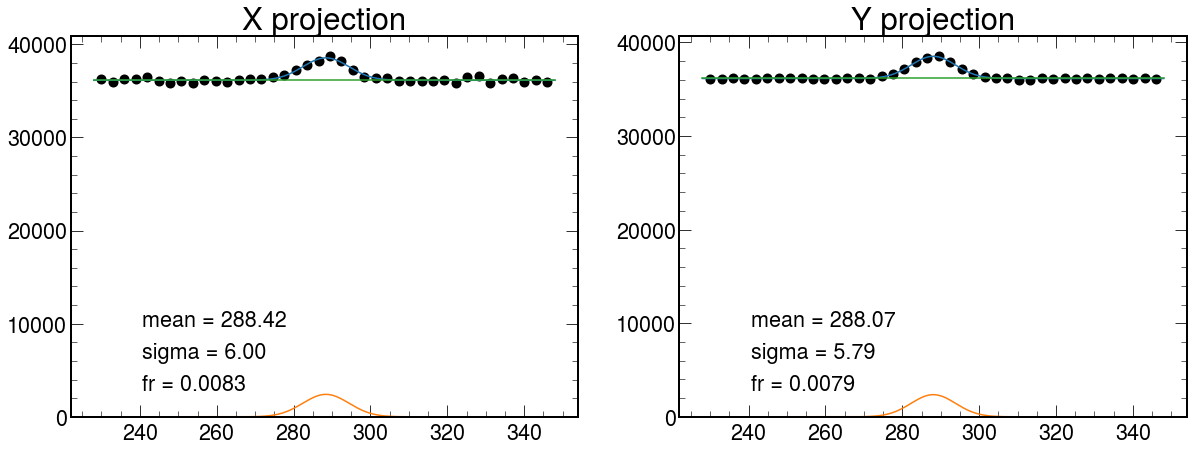

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))

#####
axs[0].plot(obs_grid, projx*plot_scaling_x, label="Sum - Model")
axs[0].plot(obs_grid, projx_sig*plot_scaling_x, label="Gauss - Signal")
axs[0].plot(obs_grid, projx_bkgr*plot_scaling_x, label="Background")
mplhep.histplot(np.histogram(data_projx_np, bins=n_bins), yerr=True, color='black', histtype='errorbar',
                markersize=17, capsize=2.5,
                markeredgewidth=1.5, zorder=1,
                elinewidth=1.5, ax=axs[0]
                )
##
axs[0].set_title('X projection')
mean_patch = mpatches.Patch(color='none', label=f'mean = {mean_x:.2f}')
sigma_patch = mpatches.Patch(color='none', label=f'sigma = {sigma_x:.2f}')
fr_patch = mpatches.Patch(color='none', label=f'fr = {fr_x:.4f}')
axs[0].legend(handles=[mean_patch, sigma_patch, fr_patch])

#####
axs[1].plot(obs_grid, projy*plot_scaling_y, label="Sum - Model")
axs[1].plot(obs_grid, projy_sig*plot_scaling_y, label="Gauss - Signal")
axs[1].plot(obs_grid, projy_bkgr*plot_scaling_y, label="Background")
mplhep.histplot(np.histogram(data_projy_np, bins=n_bins), yerr=True, color='black', histtype='errorbar',
                markersize=17, capsize=2.5,
                markeredgewidth=1.5, zorder=1,
                elinewidth=1.5, ax=axs[1]
                )
##
mean_patch = mpatches.Patch(color='none', label=f'mean = {mean_y:.2f}')
sigma_patch = mpatches.Patch(color='none', label=f'sigma = {sigma_y:.2f}')
fr_patch = mpatches.Patch(color='none', label=f'fr = {fr_y:.4f}')
axs[1].legend(handles=[mean_patch, sigma_patch, fr_patch])
axs[1].set_title('Y projection')
plt.show()

In [35]:
sum(ima_x)*(1-frac)/n_bins

<tf.Tensor: shape=(), dtype=float64, numpy=36152.61606580653>

### chi2

In [33]:
from scipy.stats import chisquare

In [34]:
chisquare(sum(ima_y)* model.pdf(obs_bin_centers), ima_y, ddof=3)

Power_divergenceResult(statistic=15.621095601055414, pvalue=1.0)

In [35]:
def my_chi2(model, bin_centers, ima):
    chi2 = (sum((ima.sum()*(model.pdf(obs_bin_centers)) - ima)**2/ima)).numpy() 
    n_dif = len(ima) - len(model.get_params())
    return chi2, n_dif

In [36]:
my_chi2(model, obs_bin_centers, ima_x)

(122.04399994082502, 117)

In [37]:
my_chi2(model, obs_bin_centers, ima_y)

(15.62109560105541, 117)

### fit errors

In [82]:
result_x.info['original']

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 6.978e+06                  │         Nfcn = 42 (42 total)         │
│ EDM = 1.67e-05 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [84]:
dict(result_x.info['original'])

{'fval': 6977817.487677813,
 'edm': 1.665128491150618e-05,
 'tolerance': 1.0,
 'nfcn': 42,
 'nfcn_total': 42,
 'up': 0.5,
 'is_valid': True,
 'has_valid_parameters': True,
 'has_accurate_covar': True,
 'has_posdef_covar': True,
 'has_made_posdef_covar': False,
 'hesse_failed': False,
 'has_covariance': True,
 'is_above_max_edm': False,
 'has_reached_call_limit': False,
 'has_parameters_at_limit': False,
 'ngrad': 0,
 'ngrad_total': 0}

In [39]:
param_hesse_x = result_x.hesse()
# param_errors, _ = result.errors()  # this returns a new FitResult if a new minimum was found
print(result_x.valid, result_x.converged)  # check if the result is still valid

True True


In [40]:
param_hesse_x

OrderedDict([(<zfit.Parameter 'fraction' floating=True value=0.007858>,
              {'error': 0.0005598983883494712}),
             (<zfit.Parameter 'mu' floating=True value=288.1>,
              {'error': 0.36664311049304776}),
             (<zfit.Parameter 'sigma' floating=True value=5.788>,
              {'error': 0.43889237678634474})])

In [ ]:
fig.savefig()

### features

* fraction
* total sum of pixel deposits
* fr*sum
* mean+error, sigma+error (X and Y)
* sigma_x - sigma_y
* mean_x - mean_y
* chi2, p-value (X and Y): sig+bkgr
* chi2, p-value (X and Y): bkgr
* fcn value (X and Y)
* n_bins > mean background (X and Y)
* fr*sum/n_bins
* result_x.info['original']

### save to dataframe

* keep amongst features "image_name" along with parsed info